## Development. Uganda
## 1. CIW

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
os.chdir('C:/Users/adamw/Desktop/Development/Uganda 2013 14 Stata/UGA_2013_UNPS_v01_M_STATA8')

## 1.1. Income

In [3]:
########### BASIC DATA ################
basic = pd.read_stata('GSEC1.dta')
basic = basic[["HHID","urban","year", "month", "region"]] 
#basic.rename(columns={'HHID':'hh'}, inplace=True)
#basic["hh"] = pd.to_numeric(basic["hh"])
pd.value_counts(basic["year"])
pd.value_counts(basic["month"])
#basic = basic.dropna(subset = ['year'])
basic["index"] = range(0,len(basic))
basic.set_index(basic["index"], inplace=True)

#Generate inflation variable (per individual) source: https://www.bou.or.ug/bou/rates_statistics/statistics.html
infl = [-0.3,0.4,0.9,1.4,0.2,-0.5,0.6,2.6,1.8,0.0,-0.7,0.1,-0.1,0.4,1.1,1.0,-1.0,-0.9,-0.1,1.1,0.3,0.4,-0.4,-0.1]#01/13, 02/13 ... 12/14
basic["inflation"] = np.zeros(len(basic))
basic["inf_idx"]= np.zeros(len(basic))
infl_idx = np.zeros(len(infl))    
for i in range(len(infl)):
    if i==0:
        infl_idx[len(infl)-i-1] = 1
    else:
        infl_idx[len(infl)-i-1] = infl_idx[len(infl)-i]/(1+(infl[len(infl)-i-1]/100))

data = np.array(basic)
for i in range(len(data)):
     data[i][6]= infl[(data[i][2]-2013)*12+data[i][3]-1]
     data[i][7]= infl_idx[(data[i][2]-2013)*12+data[i][3]-1]       
 
dollars = 2760 #approximately for 2014 year (December)
# https://freecurrencyrates.com/en/exchange-rate-history/USD-UGX/2014/yahoo

# to do: convert array into data frame
basic2 = pd.DataFrame(data = data, columns=["HHID","urban","year", "month", "region","index", "inflation", "infl_idx"] )

In [4]:
# Income: 
#labor & business income: in US dollars

#read data
labor = pd.read_stata("GSEC8_1.dta")

#pick relevant columns
labor = labor[["HHID", "PID", "h8q36a", "h8q36b", "h8q36c", "h8q36d", "h8q36e", "h8q36f", "h8q36g", "h8q30a", "h8q30b",
               "h8q31a", "h8q31b", "h8q31c", "h8q43", "h8q44", "h8q44b", "h8q45a", "h8q45b", "h8q45c"]]
#First job
#h8q36a	During the last 7 days, how many hours did [NAME] work on each day?	Sun
#h8q36b	During the last 7 days, how many hours did [NAME] work on each day?	Mon
#h8q36c	During the last 7 days, how many hours did [NAME] work on each day?	Tue
#h8q36d	During the last 7 days, how many hours did [NAME] work on each day?	Wed
#h8q36e	During the last 7 days, how many hours did [NAME] work on each day?	Thu
#h8q36f	During the last 7 days, how many hours did [NAME] work on each day?	Fri
#h8q36g	During the last 7 days, how many hours did [NAME] work on each day?  Sat
#h8q30a	During the last 12 months, for how many months did [NAME] work in this job?
#h8q30b	During the 12 months, on average how many weeks per month did [NAME] work in thi
#h8q31a	How much was [Name]'s last cash payment for the main job ?
#h8q31b	How much did [NAME] receive in kind for the main job during the last week?
#h8q31c	What period of time did this payment cover?
#Second job
#h8q43	   IN THE LAST 7 DAYS, how many hours did [NAME] actually work at the second income
#h8q44    During the last 12 months, for how many months did [NAME] work in this job?
#h8q44b	During the last month, how many weeks per month did [NAME] work in this job?
#h8q45a	How much was [Name]'s last cash payment for the second job?	
#h8q45b	How much was [NAME]’s last cash payment and the estimated value of what [NAME] l	
#h8q45c	What period of time did this payment cover?

#Sum hours per week in main job
labor["weekhours1"] = labor["h8q36a"]+labor["h8q36b"]+labor["h8q36c"]+labor["h8q36d"]+labor["h8q36e"]+labor["h8q36f"]+labor["h8q36g"]

#Count work days
labor["weekdays1"]=(labor["h8q36a"]!=0)*1+(labor["h8q36b"]!=0)*1+(labor["h8q36c"]!=0)*1+(labor["h8q36d"]!=0)*1+(labor["h8q36e"]!=0)*1+(labor["h8q36f"]!=0)*1+(labor["h8q36g"]!=0)*1

#Drop hours per week
labor = labor[["HHID", "PID", "weekhours1", "weekdays1", "h8q30a", "h8q30b",
               "h8q31a", "h8q31b", "h8q31c", "h8q43", "h8q44", "h8q44b", "h8q45a", "h8q45b", "h8q45c"]]

#Rename columns
labor.columns = ["hh","pid", "weekhours1", "weekdays1", "months1","weeks1", "cash1","inkind1", "time1","weekhours2","months2","weeks2", "cash2","inkind2", "time2"]

#Sum value in cash and in kind
labor["pay1"] = labor.loc[:,["cash1","inkind1"]].sum(axis=1)
labor["pay2"] = labor.loc[:,["cash2","inkind2"]].sum(axis=1)

#Remove data about payment in cash and in kind
del labor["cash1"], labor["inkind1"], labor["cash2"], labor["inkind2"]

#Creating week wages
labor.loc[labor.time1 == "Day", 'pay1'] = labor.loc[labor.time1 == "Day", 'pay1']*labor.loc[labor.time1 == "Day", 'weekdays1']
labor.loc[labor.time1 == "Month", 'pay1'] = labor.loc[labor.time1 == "Month", 'pay1']/(30/7)
labor.loc[labor.time1 == "Hour", 'pay1'] = labor.loc[labor.time1 == "Hour", 'pay1']*labor.loc[labor.time1 == "Day", 'weekhours1']


labor.loc[labor.time1 == "Day", 'pay2'] = labor.loc[labor.time1 == "Day", 'pay2']*5
labor.loc[labor.time1 == "Month", 'pay2'] = labor.loc[labor.time1 == "Month", 'pay2']/(30/7)
labor.loc[labor.time1 == "Hour", 'pay2'] = labor.loc[labor.time1 == "Hour", 'pay2']*labor.loc[labor.time1 == "Day", 'weekhours2']

labor["wage1"] = labor.months1*labor.weeks1*labor.pay1
labor["wage2"] = labor.months2*labor.weeks2*labor.pay2

labor_HH = labor.groupby(by="hh")[["wage1","wage2"]].sum()
labor_HH["wage_total"] = labor_HH.loc[:,["wage1","wage2"]].sum(axis=1)
labor_HH= labor_HH.replace(0, np.nan)

labor_HH["hh"] = np.array(labor_HH.index.values)
summaryw = labor_HH.describe()
print(summaryw)

              wage1         wage2    wage_total
count        962.00        227.00      1,130.00
mean   3,832,861.81  1,877,169.52  3,640,115.53
std    5,706,683.78  7,497,425.53  6,312,524.13
min       18,000.00     15,000.00     15,000.00
25%      842,333.33    120,000.00    560,000.00
50%    2,240,000.00    270,000.00  1,924,000.00
75%    4,480,000.00  1,120,000.00  4,194,000.00
max   60,592,000.00 96,000,000.00 96,000,000.00


In [5]:
#Business income
business = pd.read_stata('GSEC12.dta')
business = business[["hhid","h12q12", "h12q13","h12q15","h12q16","h12q17"]]
business.rename(columns={'hhid':'hh'}, inplace=True)
business.rename(columns={'h12q13':'revenue'}, inplace=True)
business["cost"] = -business.loc[:,["h12q15","h12q16","h12q17"]].sum(axis=1)
business["bs_profit"] = business.loc[:,["revenue","cost"]].sum(axis=1)
business["bs_profit"] = business["bs_profit"].replace(0,np.nan)
business = business[["hh","bs_profit"]]
business = business.groupby(by="hh").sum()
business["hh"] = np.array(business.index.values)
business = business.replace(0, np.nan)
summarybus = business.describe()
print(summarybus)

          bs_profit
count      1,385.00
mean     549,839.61
std    2,063,280.20
min   -6,060,000.00
25%       50,000.00
50%      160,000.00
75%      440,000.00
max   33,180,000.00


In [6]:
#Other income
other = pd.read_stata('GSEC11B.dta')
other = other[["HHID","h11q5","h11q6"]]
other.rename(columns={'HHID':'hh'}, inplace=True)
other["other_inc"] = other.loc[:,["h11q5","h11q6"]].sum(axis=1)
other = other[["hh","other_inc"]]
other = other.groupby(by="hh").sum()
other = other.replace(0, np.nan)
other["hh"] = np.array(other.index.values)
summaryo = other.describe()
print(summaryo)

          other_inc
count      1,158.00
mean   1,470,001.63
std    3,399,833.72
min           80.00
25%      170,000.00
50%      400,000.00
75%    1,200,000.00
max   52,650,000.00


In [7]:
#THE WHOLE INCOME 2nd way
income2 = pd.read_stata('GSEC11A.dta')
#h11q5	Amount received during the past 12 months.[SHILLINGS]
#h11q6	Amount received [IN-KIND]during the past 12 months.[SHILLINGS]
income2 = income2[["HHID", "h11q5", "h11q6"]]
income2.rename(columns={'HHID':'hh'}, inplace=True)
income2["total income"] = income2.loc[:,["h11q5","h11q6"]].sum(axis=1)
income2 = income2[["hh","total income"]]
income2 = income2.groupby(by="hh").sum()
income2["hh"] = np.array(income2.index.values)
income2 = income2.replace(0, np.nan)
summarinc2 = income2.describe()
print(summarinc2)

       total income
count        241.00
mean   2,802,309.13
std    4,888,735.58
min        8,000.00
25%      250,000.00
50%      960,000.00
75%    3,000,000.00
max   35,000,000.00


In [8]:
#merge
income_gsec = pd.merge(labor_HH, business, on="hh", how="outer")
income_gsec = pd.merge(income_gsec, other, on="hh", how="outer")

income_gsec["total_labor_income"] = income_gsec["wage_total"]+income_gsec["bs_profit"]+income_gsec["other_inc"]

inc_lab = income_gsec[["hh", "total_labor_income"]]
inc_lab.columns = ["HHID", "total_labor_income"]
sumlab = income_gsec[["wage_total","bs_profit", "other_inc"]].describe()
print(sumlab)

         wage_total     bs_profit     other_inc
count      1,130.00      1,385.00      1,158.00
mean   3,640,115.53    549,839.61  1,470,001.63
std    6,312,524.13  2,063,280.20  3,399,833.72
min       15,000.00 -6,060,000.00         80.00
25%      560,000.00     50,000.00    170,000.00
50%    1,924,000.00    160,000.00    400,000.00
75%    4,194,000.00    440,000.00  1,200,000.00
max   96,000,000.00 33,180,000.00 52,650,000.00


C:\Users\adamw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: FutureWarning: 'hh' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
#### AGRICULTURE

In [10]:
# Season A

#OWNER
ag2a = pd.read_stata('AGSEC2A.dta')
ag2a = ag2a[["HHID", "a2aq14"]]
ag2a.columns = ["HHID", "land_owner"]
#a2aq14  how much rent did you or will you receive (if share-cropped–out give the estimated cash value) during the two cropping seasons? 
ag2a = ag2a.groupby(by="HHID")[["land_owner"]].sum()
ag2a["HHID"] = np.array(ag2a.index.values)


#NON-OWNER
ag2b = pd.read_stata('AGSEC2B.dta')
ag2b = ag2b[["HHID", "a2bq9", "a2bq13"]]
#a2bq9	A2BQ9:How much rent did you or will you pay to the land owner during the two cro
#a2bq13	A2BQ16:How much rent did you or will you receive (if sharecropped -out give the
ag2b = ag2b.groupby(by="HHID")[["a2bq9", "a2bq13"]].sum()
ag2b["rent_noowner"] = ag2b["a2bq9"].fillna(0) - ag2b["a2bq13"].fillna(0)
ag2b["rent_noowner"] = ag2b["rent_noowner"].replace(0, np.nan)
ag2b = ag2b[["rent_noowner"]]
ag2b["HHID"] = np.array(ag2b.index.values)

# Fertilizers & labor costs
ag3a = pd.read_stata('AGSEC3A.dta')
ag3a = ag3a[["HHID", "a3aq8", "a3aq18", "a3aq27","a3aq36"]]
#a3aq8	   A3AQ8:What was the value of the purchase? (ORGANIC FERTILIZERS)
#a3aq18	A3AQ18:What was the value of the purchases? (INORGANIC/CHEMICAL FERTILIZERS)
#a3aq27	A3AQ27:What was the value of the purchase? (PESTICIDES)
#a3aq36	A3BQ36:How much did you pay including the value in-kind payments for these days (HIRED LABOUR)
#Hired labour for all tasks during the first season of 2013:
#such as land preparation and sowing, input application,
#weeding and pruning, harvesting, etc
ag3a = ag3a.groupby(by="HHID")[["a3aq8", "a3aq18", "a3aq27","a3aq36"]].sum()
ag3a["fert_lab_c"] = ag3a["a3aq8"].fillna(0)+ ag3a["a3aq18"].fillna(0) + ag3a["a3aq27"].fillna(0) + ag3a["a3aq36"].fillna(0)
ag3a["fert_lab_c"] = ag3a["fert_lab_c"].replace(0, np.nan)
ag3a = ag3a[["fert_lab_c"]]
ag3a["HHID"] = np.array(ag3a.index.values)

# Seeds costs
ag4a = pd.read_stata('AGSEC4A.dta')
ag4a = ag4a[["HHID", "a4aq15"]]
#a4aq15	How much did you pay for all purchased seeds/seedlings used on this crop
ag4a = ag4a.groupby(by="HHID")[["a4aq15"]].sum()
ag4a.columns = ["seeds_c"]
ag4a["HHID"] = np.array(ag4a.index.values)

# Output
ag5a = pd.read_stata('agsec5a.dta')
ag5a = ag5a[["HHID","cropID","a5aq6a","a5aq6c","a5aq6d", "a5aq7a", "a5aq7c", "a5aq8"]]
ag5a.columns = ["HHID", "cropID", "total","unit", "tokg", "sell", "unit2", "value_sells"]
#a5aq6a	Quantity of the crop harvested in 2013
#a5aq6b	Unit of quantity for the crop harvested
#a5aq6d	Corvension factor into kgs per crop
#a5aq7a	A5AQ7A:Quantity of the crop harvested in 2013 (SOLD)
#a5aq7c	A5AQ7C:unit of quantity for the crop harvested (SOLD)
#a5aq8	   A5AQ8:What was the value? (SOLD)

# Convert all quantitites to kilos:
#get median conversations (self-reported values)
conversion_kg = ag5a.groupby(by="unit")[["tokg"]].median()
conversion_kg.reset_index(inplace=True)
conversion_kg.loc[conversion_kg.unit=="Kilogram (KG)", "tokg"] = 1
# Redefine heaps manually
conversion_kg.loc[conversion_kg.unit=="Heap (Small)", "tokg"] = 3
conversion_kg.loc[conversion_kg.unit=="Heap (Medium)", "tokg"] = 4.5
conversion_kg.loc[conversion_kg.unit=="Heap (Large)", "tokg"] = 6
conversion_kg.columns = ["unit","kgconverter"]

#merge ag5a and converter
ag5a = ag5a.merge(conversion_kg, on="unit", how="left")

# Convert to kg
ag5a[["total", "sell"]] = ag5a[["total", "sell"]].multiply(ag5a["kgconverter"], axis="index")

#Prices
ag5a["prices"] = ag5a.value_sells.div(ag5a.sell, axis=0) 
prices_sell = ag5a.groupby(by=["cropID"])[["prices"]].median()
prices_sell.reset_index(inplace=True)
prices_sell.columns=["cropID","med_prices"]
prices_sell.loc[prices_sell.med_prices.isnull()]=prices_sell["med_prices"].median()


# Calculate the value of yields (sell prices)
ag5a = ag5a.merge(prices_sell, on="cropID", how="left")
#ag5a.loc[ag5a.prices>9999999999, "prices"] = 500.00 #there was some weird price = inf so I changed it manually
ag5a["value_produced"] = ag5a["total"]*ag5a["med_prices"]

ag5a= ag5a.replace(0, np.nan)
#ag5a["HHID"] = np.array(ag5a.index.values)
sumag5a = ag5a.describe()
#print(sumag5a)

# Merge datasets
agrica = pd.merge(ag2a, ag2b, on='HHID', how='outer')
agrica = pd.merge(agrica, ag3a, on='HHID', how='outer')
agrica = pd.merge(agrica, ag4a, on='HHID', how='outer')
agrica = pd.merge(agrica, ag5a, on='HHID', how='outer')
#agrica.reset_index(inplace=True)

# Calculate income
agrica["cost_agra"] = -agrica.loc[:,["fet_lab_c","seeds_c","trans_cost"]].sum(axis=1)
agrica["profit_agra"] = agrica.loc[:,["value_produced","rent_owner","rent_noowner","cost_agra"]].sum(axis=1)
agrica= agrica.replace(0, np.nan)
agrica["HHID"] = pd.to_numeric(agrica["HHID"])
agA = agrica[["HHID", "profit_agra"]]

#remove outliers
agA["profit_agra"] = agA.loc[(agA.profit_agra>agA.profit_agra.quantile(q=0.02)) & (agA.profit_agra<agA.profit_agra.quantile(q=0.98)),"profit_agra"]

suma = agA.describe()
print(suma)

                HHID  profit_agra
count      10,879.00     9,574.00
mean  242,960,776.22   107,680.52
std   122,585,203.15   146,655.69
min     1,020,401.00   -87,571.43
25%   140,065,401.00    18,000.00
50%   254,100,401.00    60,000.00
75%   356,020,401.00   144,000.00
max   430,100,401.00   870,000.00


C:\Users\adamw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: FutureWarning: 'HHID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\adamw\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
C:\Users\adamw\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
#Season B

# Fertilizers & labor costs
ag3b = pd.read_stata('AGSEC3B.dta')
ag3b = ag3b[["HHID", "a3bq8", "a3bq18", "a3bq27","a3bq36"]]
#a3aq8	   A3AQ8:What was the value of the purchase? (ORGANIC FERTILIZERS)
#a3aq18	A3AQ18:What was the value of the purchases? (INORGANIC/CHEMICAL FERTILIZERS)
#a3aq27	A3AQ27:What was the value of the purchase? (PESTICIDES)
#a3aq36	A3BQ36:How much did you pay including the value in-kind payments for these days (HIRED LABOUR)
#Hired labour for all tasks during the first season of 2013:
#such as land preparation and sowing, input application,
#weeding and pruning, harvesting, etc
ag3b = ag3b.groupby(by="HHID")[["a3bq8", "a3bq18", "a3bq27","a3bq36"]].sum()
ag3b["fert_lab_c"] = ag3b["a3bq8"].fillna(0)+ ag3b["a3bq18"].fillna(0) + ag3b["a3bq27"].fillna(0) + ag3b["a3bq36"].fillna(0)
ag3b["fert_lab_c"] = ag3b["fert_lab_c"].replace(0, np.nan)
ag3b = ag3b[["fert_lab_c"]]
ag3b["HHID"] = np.array(ag3b.index.values)

# Seeds costs
ag4b = pd.read_stata('AGSEC4B.dta')
ag4b = ag4b[["HHID", "a4bq15"]]
#a4aq15	How much did you pay for all purchased seeds/seedlings used on this crop
ag4b = ag4b.groupby(by="HHID")[["a4bq15"]].sum()
ag4b.columns = ["seeds_c"]
ag4b["HHID"] = np.array(ag4b.index.values)

# Output
ag5b = pd.read_stata('agsec5b.dta')
ag5b = ag5b[["HHID","cropID","a5bq6a","a5bq6c","a5bq6d", "a5bq7a", "a5bq7c", "a5bq8"]]
ag5b.columns = ["HHID", "cropID", "total","unit", "tokg", "sell", "unit2", "value_sells"]
#a5aq6a	Quantity of the crop harvested in 2013
#a5aq6b	Unit of quantity for the crop harvested
#a5aq6d	Corvension factor into kgs per crop
#a5aq7a	A5AQ7A:Quantity of the crop harvested in 2013 (SOLD)
#a5aq7c	A5AQ7C:unit of quantity for the crop harvested (SOLD)
#a5aq8	   A5AQ8:What was the value? (SOLD)

# Convert all quantitites to kilos:
#get median conversations (self-reported values)
conversion_kg = ag5b.groupby(by="unit")[["tokg"]].median()
conversion_kg.reset_index(inplace=True)
conversion_kg.loc[conversion_kg.unit=="Kilogram (KG)", "tokg"] = 1
# Redefine heaps manually
conversion_kg.loc[conversion_kg.unit=="Heap (Small)", "tokg"] = 3
conversion_kg.loc[conversion_kg.unit=="Heap (Medium)", "tokg"] = 4.5
conversion_kg.loc[conversion_kg.unit=="Heap (Large)", "tokg"] = 6
conversion_kg.columns = ["unit","kgconverter"]

#merge ag5a and converter
ag5b = ag5b.merge(conversion_kg, on="unit", how="left")

# Convert to kg
ag5b[["total", "sell"]] = ag5b[["total", "sell"]].multiply(ag5b["kgconverter"], axis="index")

#Prices
ag5b["prices"] = ag5b.value_sells.div(ag5b.sell, axis=0) 
prices_sell = ag5b.groupby(by=["cropID"])[["prices"]].median()
prices_sell.reset_index(inplace=True)
prices_sell.columns=["cropID","med_prices"]
prices_sell.loc[prices_sell.med_prices.isnull()]=prices_sell["med_prices"].median()


# Calculate the value of yields (sell prices)
ag5b = ag5b.merge(prices_sell, on="cropID", how="left")
#ag5b.loc[ag5b.prices>9999999999, "prices"] = 500.00 #there was some weird price = inf so I changed it manually
ag5b["value_produced"] = ag5b["total"]*ag5b["med_prices"]

ag5b= ag5b.replace(0, np.nan)
#ag5b["HHID"] = np.array(ag5b.index.values)
sumag5b = ag5b.describe()
print(sumag5b)

                HHID    cropID      total      tokg      sell  value_sells  \
count      10,424.00 10,415.00   8,515.00  6,664.00  3,152.00     3,188.00   
mean  242,170,883.72    447.35     281.70     45.59    334.45   219,054.65   
std   126,929,847.82    257.38   2,059.39    190.09    960.81   410,605.97   
min     1,020,401.00    111.00       1.00      0.02      1.00         1.00   
25%   125,100,401.00    210.00      50.00     10.00     60.00    40,000.00   
50%   260,560,401.50    520.00     100.00     17.00    130.00   100,000.00   
75%   355,072,901.00    700.00     280.00     80.00    312.00   230,250.00   
max   430,100,401.00    890.00 180,000.00 14,000.00 32,000.00 7,200,000.00   

       kgconverter   prices  med_prices  value_produced  
count     8,515.00 3,150.00   10,405.00        8,502.00  
mean         32.72      inf      751.10      167,663.00  
std          40.36      nan      546.55      852,251.19  
min           0.50     0.05       71.43          500.00  
25%    

In [12]:
# Merge datasets
agricb = pd.merge(ag3b, ag4b, on='HHID', how='outer')
agricb = pd.merge(agricb, ag5b, on='HHID', how='outer')
#agrica.reset_index(inplace=True)

# Calculate income
agricb["cost_agra"] = -agricb.loc[:,["fet_lab_c","seeds_c","trans_cost"]].sum(axis=1)
agricb["profit_agrb"] = agricb.loc[:,["value_produced","rent_owner","rent_noowner","cost_agra"]].sum(axis=1)
agricb= agricb.replace(0, np.nan)
#agricb["HHID"] = np.array(agricb.index.values)
#agricb = agricb.groupby(by="HHID").sum()
#agricb["HHID"] = pd.to_numeric(agricb["HHID"])
agB = agricb[["HHID", "profit_agrb"]]

#remove outliers
agB["profit_agrb"] = agB.loc[(agB.profit_agrb>agB.profit_agrb.quantile(q=0.02)) & (agB.profit_agrb<agB.profit_agrb.quantile(q=0.98)),"profit_agrb"]

suma = agB.describe()
print(suma)

                HHID  profit_agrb
count      10,435.00     8,873.00
mean  242,159,099.79   105,480.37
std   126,912,185.00   135,866.91
min     1,020,401.00   -54,900.00
25%   125,120,401.00    22,000.00
50%   261,020,402.00    60,000.00
75%   355,070,401.00   135,000.00
max   430,100,401.00   797,442.31


C:\Users\adamw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: FutureWarning: 'HHID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\adamw\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
C:\Users\adamw\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app

In [13]:
# Livestock
#Big Animals
ag6a = pd.read_stata('AGSEC6A.dta')
ag6a = ag6a[["HHID", "LiveStockID", "a6aq13a", "a6aq13b", "a6aq14a", "a6aq14b", "a6aq15"]]
#LiveStockID	Livestock code
#a6aq13a	How many <b>[LiveStockID]</b> did you buy to raise during the last 12 months?
#a6aq13b	What was, on average, the value of each [LiveStockID] bought?
#a6aq14a	 How many <b>[LiveStockID]</b> did you sell during the last 12 months?
#a6aq15	A6AQ15: How many <b>[LiveStockID]</b> did you slaughter in the last 12 months?
ag6a.columns = ["HHID","lvstid","amount_bought", "buy_price", "amount_sold", "sell_price", "amount_consumed"]
ag6a["value_bought"] = ag6a["amount_bought"]*ag6a["buy_price"]
ag6a["value_sold_n_cons"] = (ag6a["amount_sold"].fillna(0)+ag6a["amount_consumed"].fillna(0))*ag6a["sell_price"]
ag6a["lvstincome_big"]=ag6a["value_sold_n_cons"].fillna(0)-ag6a["value_bought"].fillna(0)
ag6a=ag6a[["HHID","lvstid","lvstincome_big"]]
ag6a = ag6a.groupby(by='HHID')[["lvstincome_big"]].sum()
#Remove outliers
ag6a["lvstincome_big"] = ag6a.loc[(ag6a.lvstincome_big>ag6a.lvstincome_big.quantile(q=0.02)) & (ag6a.lvstincome_big<ag6a.lvstincome_big.quantile(q=0.98)),"lvstincome_big"]
ag6a= ag6a.replace(0, np.nan)
ag6a["HHID"] = np.array(ag6a.index.values)    

#Small animals
ag6b = pd.read_stata('agsec6b.dta', convert_categoricals=False)
ag6b = ag6b[["HHID", "ALiveStock_Small_ID", "a6bq13a", "a6bq13b", "a6bq14a", "a6bq14b", "a6bq15"]]
#ALiveStock_Small_ID	Small Animals
#a6bq13a	A6BQ13A: How many livestock did you buy to raise during the lat 12 days
#a6bq13b	A6BQ13B: Average value of each bought
#a6bq14a	A6BQ14A: How many livestock did you sell alive during the last 12 months	
#a6bq14b	A6BQ14B: Average value of each sold
#a6bq15	A6BQ15: How many livestock did you slaughter during the last 12 months
ag6b.columns = ["HHID","lvstid","amount_bought", "buy_price", "amount_sold", "sell_price", "amount_consumed"]
ag6b["value_bought"] = ag6b["amount_bought"]*ag6b["buy_price"]
ag6b["value_sold_n_cons"] = (ag6b["amount_sold"].fillna(0)+ag6b["amount_consumed"].fillna(0))*ag6b["sell_price"]
ag6b["lvstincome_small"]=ag6b["value_sold_n_cons"].fillna(0)-ag6b["value_bought"].fillna(0)
ag6b=ag6b[["HHID","lvstid","lvstincome_small"]]
ag6b = ag6b.groupby(by='HHID')[["lvstincome_small"]].sum()
ag6b["lvstincome_small"] = ag6b.loc[(ag6b.lvstincome_small>ag6b.lvstincome_small.quantile(q=0.02)) & (ag6b.lvstincome_small<ag6b.lvstincome_small.quantile(q=0.98)),"lvstincome_small"]
ag6b= ag6b.replace(0, np.nan)
ag6b["HHID"] = np.array(ag6b.index.values)   

#Poultry animals
ag6c = pd.read_stata('agsec6c.dta', convert_categoricals=False)
ag6c = ag6c[["HHID", "APCode", "a6cq13a", "a6cq13b", "a6cq14a", "a6cq14b", "a6cq15"]]
#ALiveStock_Small_ID	Small Animals
#a6cq13a	A6cQ13A: How many livestock did you buy to raise during the lat 12 days
#a6cq13b	A6cQ13B: Average value of each bought
#a6cq14a	A6cQ14A: How many livestock did you sell alive during the last 12 months	
#a6cq14b	A6cQ14B: Average value of each sold
#a6cq15	A6cQ15: How many livestock did you slaughter during the last 12 months
ag6c.columns = ["HHID","lvstid","amount_bought", "buy_price", "amount_sold", "sell_price", "amount_consumed"]
ag6c["value_bought"] = ag6c["amount_bought"]*ag6c["buy_price"]
ag6c["value_sold_n_cons"] = (ag6c["amount_sold"].fillna(0)+ag6c["amount_consumed"].fillna(0))*ag6c["sell_price"]
ag6c["lvstincome_poultry"]=ag6c["value_sold_n_cons"].fillna(0)-ag6c["value_bought"].fillna(0)
ag6c=ag6c[["HHID","lvstid","lvstincome_poultry"]]
ag6c = ag6c.groupby(by='HHID')[["lvstincome_poultry"]].sum()
#Remove outliers
ag6c["lvstincome_poultry"] = ag6c.loc[(ag6c.lvstincome_poultry>ag6c.lvstincome_poultry.quantile(q=0.02)) & (ag6c.lvstincome_poultry<ag6c.lvstincome_poultry.quantile(q=0.98)),"lvstincome_poultry"]
ag6c= ag6c.replace(0, np.nan)
print(ag6c.describe())
ag6c["HHID"] = np.array(ag6c.index.values) 

# Livestock inputs
ag7 = pd.read_stata('AGSEC7.dta')
ag7 = ag7[["HHID", "AGroup_ID", "a7bq2e", "a7bq3f", "a7bq5d", "a7bq6c", "a7bq7c", "a7bq8c"]]
#AGroup_ID	Animal Groups
#a7bq2e	A7BQ2E: How much has this household paid to feed the [AGroup_ID] in the past 12
#a7bq3f	A7BQ3F: How much has this household paid to access the main water sources for th
#a7bq5d	A7BQ5D: What was the total cost of vaccination, including vaccine and profession
# a7bq6c	A7BQ6C: What was the total cost for deworming, including cost of dewormer and pr
#a7bq7c	A7BQ7C: What was the total cost of the treatment of the [AGroup_ID] against tick
#a7bq8c	A7BQ8C: What was the total cost of the curative treatment for the [AGroup_ID]
ag7["lvstinput"] = ag7[["a7bq2e", "a7bq3f", "a7bq5d", "a7bq6c", "a7bq7c", "a7bq8c"]].sum(axis=1)
ag7 = ag7[["HHID", "AGroup_ID","lvstinput"]]
ag7 = ag7.groupby(by="HHID").sum()
ag7= ag7.replace(0, np.nan)
ag7["lvstinput"] = ag7.loc[(ag7.lvstinput>ag7.lvstinput.quantile(q=0.05)) & (ag7.lvstinput<ag7.lvstinput.quantile(q=0.90)),"lvstinput"]
print(ag7.describe())
ag7["HHID"] = np.array(ag7.index.values)


## Livestock Outputs - milk
ag8B = pd.read_stata('AGSEC8B.dta')
ag8B = ag8B[["HHID", "AGroup_ID", "a8bq1", "a8bq2", "a8bq3", "a8bq5_1", "a8bq6", "a8bq9"]]
ag8B.columns = ["HHID", "AGroup_ID", "num_anim", "milked_months", "day_produc_per_animal", "milk_sold", "milk_convert", "year_earnings"]
#HHID	Household ID	
#AGroup_ID	Animal Groups
#a8bq1	A8BQ1: How many of the following livestock types were milked in the last 12 mont
#a8bq2	A8BQ2: How many MONTHS on average, were [AGoup_ID] milked for?
#a8bq3	A8BQ3: What was the average [AGroup_ID] milk production per day per milking animal
#a8bq5_1	A8BQ5_1 How many litres of [AGroup_ID] liquid milk did you sell per day?	
#a8bq6	A8BQ6: How much of the milk produced by [AGroup_ID] did you convert EACH DAY into dairy prod.
#a8bq9	A8BQ9: How much has this household earned by selling [AGroup_ID] milk AND DAIRY
#if they claim they sold more than produced, input the produced amount as sold.
ag8B.loc[ag8B.milk_sold>(ag8B.num_anim*ag8B.day_produc_per_animal), "milk_sold"] = ag8B.num_anim*ag8B.day_produc_per_animal
ag8B["earnings_per_day"] = ag8B["year_earnings"]/ag8B["milked_months"]/30
ag8B["price_of_1l_milk"] = ag8B["earnings_per_day"]/(ag8B["milk_sold"] + ag8B["milk_convert"])
ag8B["price_of_1l_milk"]= ag8B["price_of_1l_milk"].replace(0, np.nan)
ag8B["price_of_1l_milk"] = ag8B["price_of_1l_milk"].mean() #fix the price of 1l of milk
#print(ag8B["price_of_1l_milk"].describe())
ag8B["production_per_day"] = ag8B["num_anim"] * ag8B["day_produc_per_animal"]
ag8B["milk_income"] = ag8B["price_of_1l_milk"]*ag8B["production_per_day"]*30*ag8B["milked_months"]
ag8B = ag8B[["HHID", "AGroup_ID", "milk_income"]]
ag8B = ag8B.groupby(by="HHID").sum()
ag8B= ag8B.replace(0, np.nan)
ag8B["milk_income"] = ag8B.loc[(ag8B.milk_income>ag8B.milk_income.quantile(q=0.02)) & (ag8B.milk_income<ag8B.milk_income.quantile(q=0.98)),"milk_income"]
print(ag8B.describe())
ag8B["HHID"] = np.array(ag8B.index.values) 

## Livestock Outputs - eggs
ag8C = pd.read_stata('AGSEC8C.dta')
ag8C = ag8C[["HHID", "AGroup_ID", "a8cq2", "a8cq3", "a8cq5"]]
#a8cq2	A8CQ2: How many[AGroup_ID] eggs did you produce in the last 3 months?	
#a8cq3	A8CQ3: How many [AGroup_ID] eggs did you sell in the last 3 months?		
#a8cq5	A8CQ5: How much has this household earned by selling [AGroup_ID] eggs in the pas
ag8C.columns = ["HHID", "AGroup_ID", "eggs_prod", "eggs_sold", "egg_earnings"]
ag8C["price_of_egg"] = ag8C["egg_earnings"]/ag8C["eggs_sold"]
ag8C["price_of_egg"] = ag8C["price_of_egg"].replace(0, np.nan)
ag8C["price_of_egg"] = ag8C["price_of_egg"].mean() #fix the price of egg'
ag8C["egg_income"] = ag8C["price_of_egg"]*ag8C["eggs_prod"]
ag8C = ag8C[["HHID", "AGroup_ID", "egg_income"]]
ag8C = ag8C.groupby(by="HHID").sum()
ag8C= ag8C.replace(0, np.nan)
ag8C["egg_income"] = ag8C.loc[(ag8C.egg_income>ag8C.egg_income.quantile(q=0.02)) & (ag8C.egg_income<ag8C.egg_income.quantile(q=0.98)),"egg_income"]
print(ag8C.describe())
ag8C["HHID"] = np.array(ag8C.index.values) 

       lvstincome_poultry
count              307.00
mean            43,463.19
std             61,124.52
min            -45,000.00
25%             -6,000.00
50%             34,000.00
75%             72,000.00
max            255,000.00
       lvstinput
count     950.00
mean   30,996.07
std    36,667.60
min     1,100.00
25%     6,000.00
50%    17,000.00
75%    40,000.00
max   176,000.00
        milk_income
count        318.00
mean   1,268,759.61
std    2,371,880.57
min       33,474.28
25%      178,529.52
50%      446,323.80
75%    1,071,177.11
max   16,737,142.40
       egg_income
count      751.00
mean    13,820.11
std      9,467.93
min      2,767.89
25%      6,919.73
50%     10,379.59
75%     17,299.32
max     55,357.82


In [14]:
#Machinery
ag10 = pd.read_stata('AGSEC10.dta')
ag10 = ag10[["HHID", "A10itemcod", "a10q8"]]
#a10q8	A10Q8:How much did your household pay to rent or borrow [ITEM] during the last 1
ag10.columns = ["HHID", "itemcd", "rent_tools_cost"]
ag10 = ag10.groupby(by="HHID").sum()
ag10= ag10.replace(0, np.nan)
ag10["rent_tools_cost"] = ag10.loc[(ag10.rent_tools_cost>ag10.rent_tools_cost.quantile(q=0.02)) & (ag10.rent_tools_cost<ag10.rent_tools_cost.quantile(q=0.95)),"rent_tools_cost"]
print(ag10.describe())
ag10["HHID"] = np.array(ag10.index.values) 

       rent_tools_cost
count           214.00
mean          9,607.01
std          13,024.85
min             900.00
25%           3,000.00
50%           5,000.00
75%          10,750.00
max          80,000.00


In [15]:
#Merge livestock
livestock = pd.merge(ag6a, ag6b, on="HHID", how='outer')
livestock = pd.merge(livestock, ag6c, on="HHID", how='outer')
livestock = pd.merge(livestock, ag7, on="HHID", how='outer')
livestock = pd.merge(livestock, ag8B, on="HHID", how='outer')
livestock = pd.merge(livestock, ag8C, on="HHID", how='outer')
livestock = pd.merge(livestock, ag10, on="HHID", how='outer')
#livestock["HHID"] = pd.to_numeric(livestock["HHID"])

livestock["revenue"] =livestock.loc[:,["lvstincome_big","lvstincome_small","lvstincome_poultry","milk_income","egg_income"]].sum(axis=1) 
livestock["cost"] = -livestock.loc[:,["lvstinput","rent_tools_cost"]].sum(axis=1) 
livestock["profit_ls"] = livestock.loc[:,["revenue","cost"]].sum(axis=1)

print(livestock["profit_ls"].describe())

ls = livestock[["HHID","profit_ls"]]
ls = ls.dropna()

count        2,488.00
mean       229,508.30
std      1,079,456.56
min       -740,000.00
25%         -1,500.00
50%              0.00
75%         60,094.90
max     17,177,142.40
Name: profit_ls, dtype: float64


C:\Users\adamw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: FutureWarning: 'HHID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
#self consumed 

c2 = pd.read_stata('GSEC15b.dta', convert_categoricals=False)
c2 = c2[["HHID","itmcd","h15bq4","h15bq5","h15bq6","h15bq7","h15bq8","h15bq9","h15bq10","h15bq11","h15bq12","h15bq13"]]
c2.columns = ["HHID","code", "purch_home_quant","purch_home_value","purch_away_quant","purch_away_value","own_quant","own_value","gift_quant","gift_value", "m_p", "gate_p"]
pricescons = c2.groupby(by="code")[["m_p", "gate_p"]].median()
#pricescons.to_csv("pricesfood10.csv")


## To get own-produced livestock consumption (and use it from the income side)
animal_c = c2.loc[c2["code"].isin([117,118,119,120,121,122,123,124,125]),["HHID","own_value"]]
animal_c = animal_c.groupby(by="HHID").sum()*52
animal_c["HHID"] = np.array(animal_c.index.values)

newid = []
for index, row in animal_c.iterrows() :
    newid.append(int(row["HHID"].replace("H", '').replace("-", '')))
animal_c["HHID"] = newid


livestock = pd.merge(livestock, animal_c, on="HHID", how="outer")
livestock.rename(columns={'own_value':'animal_c'}, inplace=True)
livestock["profit_ls"] = livestock.loc[:,["profit_ls","animal_c"]].sum(axis=1)

C:\Users\adamw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: FutureWarning: 'HHID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
# Merge all agriculture
agA = agA.groupby(by="HHID").sum()
agA["HHID"] = np.array(agA.index.values) 
agB = agB.groupby(by="HHID").sum()
agB["HHID"] = np.array(agB.index.values)

farm = pd.merge(agA, agB, on="HHID", how="outer")
farm = pd.merge(farm, ls, on="HHID", how="outer")

farm["total_farm_income"] = farm["profit_agra"]+farm["profit_agrb"]+farm["profit_ls"]
farm = farm[["HHID", "total_farm_income"]]
farm = farm.dropna()
inc_agr = farm
summaryfarm = farm.describe()
#print(summaryfarm)
farm_arr = np.array(farm["total_farm_income"])
#plt.hist(farm_arr[0:100], 40)


newid = []
for index, row in inc_lab.iterrows() :
    newid.append(int(row["HHID"].replace("H", '').replace("-", '')))
inc_lab["HHID"] = newid

newid = []
for index, row in basic2.iterrows() :
    newid.append(int(row["HHID"].replace("H", '').replace("-", '')))
basic2["HHID"] = newid


#### MERGE LABOR INCOME AND FARM INCOME
inc = pd.merge(inc_lab, inc_agr, on="HHID", how="outer")

inc["Total_total_income"] = inc.loc[:,["total_labor_income", "total_farm_income"]].sum(axis=1)
inc = inc[["HHID","Total_total_income"]]
#inc.columns = ["Total_total_income"]
#remove outliers
inc.Total_total_income = inc.loc[(inc.Total_total_income>inc.Total_total_income.quantile(q=0.002)) & (inc.Total_total_income<inc.Total_total_income.quantile(q=0.998)),"Total_total_income"]
inc.Total_total_income = inc.Total_total_income.replace(0, np.nan)
inc= inc.dropna()
print(inc.describe())

C:\Users\adamw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: FutureWarning: 'HHID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\adamw\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                HHID  Total_total_income
count       2,231.00            2,231.00
mean  247,258,778.64        1,536,085.71
std   119,627,284.94        2,660,246.65
min     1,020,401.00         -218,600.00
25%   150,555,401.00          326,745.83
50%   254,030,402.00          773,000.00
75%   359,025,401.00        1,664,337.96
max   430,100,401.00       29,278,000.00


In [18]:
# Get data at individual level
personal = pd.read_stata("GSEC2.dta")
personal = personal[["HHID","PID","h2q3","h2q4","h2q8"]]
#HHID	Household Unique Identifier in 2013/14
#PID	PID
#h2q3	SEX
#h2q4	What is the relationship of [NAME] to the head of the household?
#h2q8	Age in Years?
newid = []
for index, row in personal.iterrows() :
    newid.append(int(row["HHID"].replace("H", '').replace("-", '')))
personal["HHID"] = newid
personal.columns = [["HHID", "PID", "sex", "relation", "age"]]
All = pd.merge(inc, basic2, on="HHID", how="outer")
personal["ishead"] = (personal.relation=="Head")*1
personal["head_age"] = np.array(personal.ishead) * np.array(personal.age)
personal2 = personal[["HHID", "head_age"]]
personal_arr = np.array(personal2)

a = []
for i in range(len(personal_arr)):
    if personal_arr[i][1]!=0 and personal_arr[i][1]<90:
        a.append(personal_arr[i])
personal_arr = a

personal = pd.DataFrame(data = personal_arr, columns=["HHID", "head_age"])
All = pd.merge(personal, All, on="HHID", how="outer")
All["Total_total_income_infl"] = All["Total_total_income"].fillna(0)*All["infl_idx"] 
All["Total_total_income_dollars"] = pd.to_numeric(All["Total_total_income_infl"]/dollars)
All["Total_total_income_dollars"]=All["Total_total_income_dollars"].replace(0,np.NaN)

In [19]:
urbani = np.array(All.loc[All.urban=="Urban", "Total_total_income_dollars"])
rurali = np.array(All.loc[All.urban=="Rural", "Total_total_income_dollars"])

In [20]:
np.nanmean(urbani)

1022.6815283856552

In [21]:
np.nanmean(rurali)

462.8371328110951

In [22]:
urbani = urbani[~np.isnan(urbani)]

In [23]:
rurali = rurali[~np.isnan(rurali)]

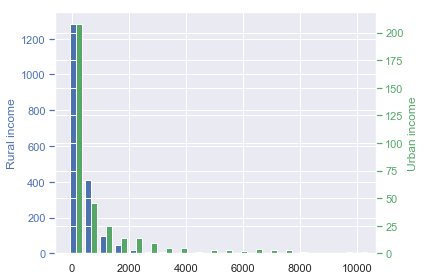

In [24]:
fig, ax1 = plt.subplots()
colors = ['b','g']
ax2 = ax1.twinx()
ax1.hist([rurali, urbani], bins=20, color=colors)
n, bins, patches = ax1.hist([rurali,urbani], bins=20)
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * 0.4
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Rural income", color=colors[0])
ax2.set_ylabel("Urban income", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
plt.tight_layout()
plt.show()

Majority of households are concentrated in the range till approximately $\$800$. Overall we can see that higher income is mainly typical for urban houselholds. 

In [25]:
urbani_log =  np.log(urbani)
rurali_log =  np.log(rurali)

C:\Users\adamw\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\adamw\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [26]:
np.var(urbani_log[~np.isnan(urbani_log)])

2.7804125344391712

In [27]:
np.var(rurali_log[~np.isnan(rurali_log)])

1.4922799173005399

[(0, 1500)]

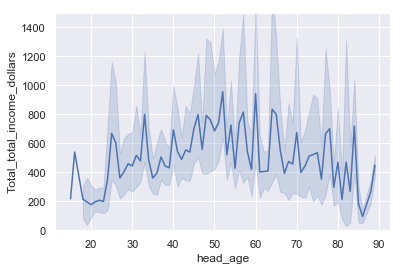

In [28]:
g=sns.lineplot(x=All.head_age, y=All.Total_total_income_dollars, data=All)
g.set(ylim=(0, 1500))

Total income distribution follows a typical lifecycle behaviour, with a pick around 50 years.
For Malawi research we can observe simialr dynamics.

## 1.2. Consumption

In [29]:
# food consumption
c2 = pd.read_stata('GSEC15B.dta', convert_categoricals=False)
c2 = c2[["HHID","itmcd","h15bq4","h15bq5","h15bq6","h15bq7","h15bq8","h15bq9","h15bq10","h15bq11","h15bq12","h15bq13"]]
c2.columns = ["HHID","code", "purch_home_quant","purch_home_value","purch_away_quant","purch_away_value","own_quant","own_value","gift_quant","gift_value", "m_p", "gate_p"]
pricescons = c2.groupby(by="code")[["m_p", "gate_p"]].median()
pricescons.to_csv("pricesfood.csv")

#Aggregate across items
c2 = c2.groupby(by="HHID")[["purch_home_quant","purch_home_value","purch_away_quant","purch_away_value","own_quant","own_value","gift_quant","gift_value"]].sum()
c2 = c2[["purch_home_value", "purch_away_value", "own_value","gift_value"]]
c2["cfood"] = c2[["purch_home_value", "purch_away_value", "own_value","gift_value"]].sum(axis=1)
c2.rename(columns={'total_value':'cfood'}, inplace=True)
c2.rename(columns={'gift_value':'cfood_gift'}, inplace=True)
c2.rename(columns={'own_value':'cfood_own'}, inplace=True)

c2["cfood_purch"] = c2.loc[:,["purch_home_value","purch_away_value"]].sum(axis=1)
c2["cfood_nogift"] = c2.loc[:,["cfood_purch","own_value"]].sum(axis=1)

# Food consumption at year level
c2 = c2[["cfood", "cfood_nogift", "cfood_own", "cfood_purch", "cfood_gift"]]*52
# Cfood is total value. cfood_nogift is total value minus gifts.
c2.reset_index(inplace=True)

data = c2

#%% NONFOOD NONDURABLE CONSUMPTION

c3 = pd.read_stata('GSEC15C.dta', convert_categoricals=False)
c3 = c3.drop(columns=['h15cq2', 'wgt_X'])
c3.columns = ["HHID","code","unit","purch_quant","purch_value","own_quant","own_value","gift_quant","gift_value", "m_p"]

#Aggregate across items
c3 = c3.groupby(by="HHID")[["purch_quant","purch_value","own_quant","own_value","gift_quant","gift_value"]].sum()

c3['cnodur'] = c3.fillna(0)["purch_value"] + c3.fillna(0)["own_value"] + c3.fillna(0)["gift_value"]
c3["cnodur_nogift"] = c3.loc[:,["purch_value","own_value"]].sum(axis=1)
c3.rename(columns={'gift_value':'cnodur_gift'}, inplace=True)
c3.rename(columns={'own_value':'cnodur_own'}, inplace=True)
c3.rename(columns={'purch_value':'cnodur_purch'}, inplace=True)

# non food non durable consumption at year level
c3 = c3[["cnodur", "cnodur_nogift", "cnodur_own", "cnodur_purch", "cnodur_gift"]]*12
c3.reset_index(inplace=True)

data = data.merge(c3, on="HHID", how="outer")

#%% DURABLE CONSUMPTION
c4 = pd.read_stata('GSEC15D.dta', convert_categoricals=False)
c4 = c4[["HHID","h15dq2","h15dq3","h15dq4","h15dq5"]]
c4.columns = ["HHID","code","unit","purch_quant","purch_value"]

c4 = c4.groupby(by="HHID")[["purch_value"]].sum()

# Durable consumption only asked for purchases
c4.rename(columns={'purch_value':'cdur'}, inplace=True)
c4.reset_index(inplace=True)

data = data.merge(c4, on="HHID", how="outer")

#####
# Urban/ Rural
u = pd.read_stata('AGSEC1.dta', convert_categoricals=False)
u = u[["hh","urban"]]
u.columns = ["HHID","urban"]

data =data.merge(u, on="HHID")
### 

#%% Create join variables
data["ctotal"] = data.loc[:,["cfood","cnodur"]].fillna(0).sum(axis=1)
data["ctotal_dur"] = data.loc[:,["cfood","cnodur","cdur"]].fillna(0).sum(axis=1)

#data["ctotal_gift"] = data.loc[:,["cfood_gift","cnodur_gift"]].sum(axis=1)
#data["ctotal_dur_gift"] = data.loc[:,["ctotal_gift","cdur_gift"]].sum(axis=1)

data["ctotal_nogift"] = data.loc[:,["cfood_nogift","cnodur_nogift"]].fillna(0).sum(axis=1)
data["ctotal_dur_nogift"] = data.loc[:,["cfood_nogift","cnodur_nogift"]].fillna(0).sum(axis=1)

data["ctotal_own"] = data.loc[:,["cfood_own","cnodur_own"]].fillna(0).sum(axis=1)
data["ctotal_dur_own"] = data.loc[:,["ctotal_own","cdur_own"]].fillna(0).sum(axis=1)

# and total over all of them
data["all"] = data.loc[:,["ctotal_dur", "ctotal_dur_nogift", "ctotal_dur_own"]].fillna(0).sum(axis=1)

cdata_short = data[["HHID","all","ctotal","ctotal_dur","ctotal_nogift","ctotal_dur_nogift","ctotal_own","ctotal_dur_own","cfood","cnodur","cdur"]]
sumc =cdata_short.describe()/dollars 

C:\Users\adamw\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [30]:
newid = []
for index, row in data.iterrows() :
    newid.append(int(row["HHID"].replace("H", '').replace("-", '')))
data["HHID"] = newid

In [31]:
All = pd.merge(All, data[["HHID","all","ctotal","ctotal_dur","ctotal_nogift","ctotal_dur_nogift","ctotal_own","ctotal_dur_own","cfood","cnodur","cdur"]], on="HHID", how="outer")

In [32]:
#remove outliers
All["all"]= All.loc[(All["all"]>All["all"].quantile(q=0.05)) & (All["all"]<All["all"].quantile(q=0.80)),"all"]

#convert to dollars
All["all"] = All["all"]/dollars

In [33]:
urbanc = np.array(All.loc[All.urban=="Urban", "all"].dropna())
ruralc = np.array(All.loc[All.urban=="Rural", "all"].dropna())

In [34]:
totalc = All["all"].dropna()
totalc.mean()

2390.4505348470475

In [35]:
urbanc.mean()

2693.0644207740816

In [36]:
ruralc.mean()

2349.918614368334

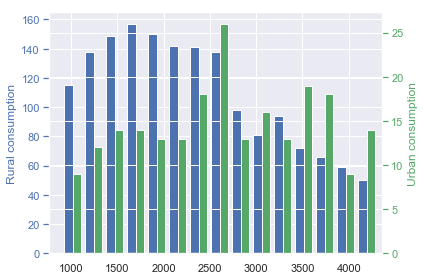

In [37]:
fig, ax1 = plt.subplots()
colors = ['b','g']
ax2 = ax1.twinx()
ax1.hist([ruralc, urbanc], bins=15, color=colors)
n, bins, patches = ax1.hist([ruralc,urbanc], bins=15)
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * 0.4
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Rural consumption", color=colors[0])
ax2.set_ylabel("Urban consumption", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
#plt.xlim(0,500000)
plt.tight_layout()
plt.show()

The histogram above demonstrates distribution of households by consumption in rural and urban areas: consumption in rural areas in general is lower compared to urban areas. There are more households in rural areas with consumption lower than approximately $\$2500$,above that value urban households prevail over the rural. Espicially large is the gap in number of households for the highest values of consumption the interval of $\$4000-5000$.

In comparison accroding to the data reported at Micro Data Survey in 2010, mean consumption per household in Uganda accounted for $\$2366$. And in our case for the survey od 2013-2014 mean od total consumption per households is $\$2390.45$, which is slightly higher than in 2010. 

Mean consumption per household in urban areas is $\$2693.06$, and in rural it is less $\$2349.92$.

Compared to other poor countries, like Malawi and Tanzania, consumption in Uganda is almost 1.5 times higher.

[(500, 3500)]

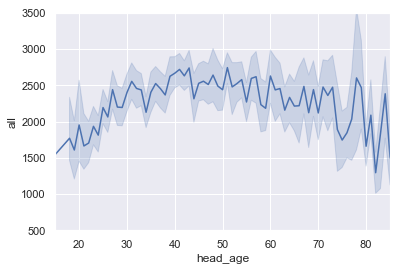

In [38]:
con_plot=sns.lineplot(x=All.head_age, y=All["all"], data=All)
con_plot.set(xlim=(15, 85))
con_plot.set(ylim=(500, 3500))

Total consumption distribution follows a typical lifecycle behaviour.

In [39]:
urbanc_log =  np.log(urbanc)
ruralc_log =  np.log(ruralc)

In [40]:
np.var(urbanc_log[~np.isnan(urbanc_log)])

0.14689333701425192

In [41]:
np.var(ruralc_log[~np.isnan(ruralc_log)])

0.15516698454832803

## 1.3. Wealth

In [42]:
w = pd.read_stata('GSEC14A.dta', convert_categoricals=False)

In [43]:
w = w[["HHID","h14q2","h14q5"]]
w.columns = ["HHID","asset","wealth_value"]
newid = []
for index, row in w.iterrows() :
    newid.append(int(row["HHID"].replace("H", '').replace("-", '')))
w["HHID"] = newid
w = w.groupby(by="HHID")[["wealth_value"]].sum()

All = pd.merge(All, w, on="HHID", how="outer")

In [44]:
#remove outliers
All["wealth_value"]= All.loc[(All["wealth_value"]>All["wealth_value"].quantile(q=0.1)) & (All["wealth_value"]<All["wealth_value"].quantile(q=0.90)),"wealth_value"]

#convert to dollars
All["wealth_value"] = All["wealth_value"]/dollars

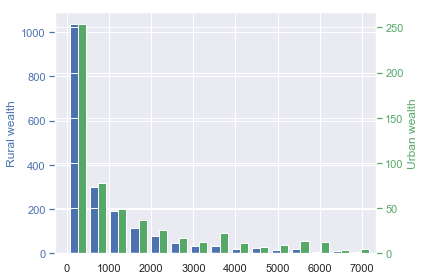

In [45]:
urbanw = np.array(All.loc[All.urban=="Urban", "wealth_value"].dropna())
ruralw = np.array(All.loc[All.urban=="Rural", "wealth_value"].dropna())

fig, ax1 = plt.subplots()
colors = ['b','g']
ax2 = ax1.twinx()
ax1.hist([ruralw, urbanw], bins=15, color=colors)
n, bins, patches = ax1.hist([ruralw,urbanw], bins=15)
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * 0.4
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Rural wealth", color=colors[0])
ax2.set_ylabel("Urban wealth", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
#plt.xlim(0,500000)
plt.tight_layout()
plt.show()

Mean of total wealth per household accounts for $\$816.28$.
Distribution of wealth across urban and rural areas follows similar distribution, mean rural wealth value is much lower than in urban areas ($\$792.89$ and $\$989.09$ respectively). Major part of households is distributed in the range of wealth below $\$500$ per household.

In [46]:
totalw = All["wealth_value"].dropna()
totalw.mean()

1123.7753710319214

In [47]:
urbanw.mean()

1444.1561493558777

In [48]:
ruralw.mean()

1031.4818892018884

[(0, 3000)]

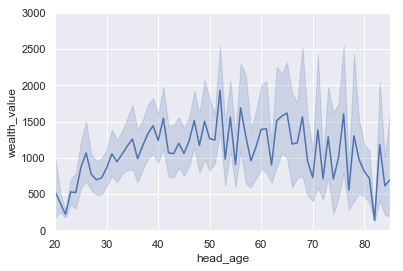

In [49]:
w_plot=sns.lineplot(x=All.head_age, y=All["wealth_value"], data=All)
w_plot.set(xlim=(20, 85))
w_plot.set(ylim=(0, 3000))
#w_plot.title=('Wealth over lifecycle')

Wealth over the lifecycle is slightly shifted to the right, compared to distributiob of consumption and income over the lifecycle. 

In [50]:
urbanw_log =  np.log(urbanw)
ruralw_log =  np.log(ruralw)

In [51]:
np.var(urbanw_log[~np.isnan(urbanw_log)])

1.7367423709717211

In [52]:
np.var(ruralw_log[~np.isnan(ruralw_log)])

1.4080460062661664

# 2. Labor Supply

In [53]:
# gender
s = pd.read_stata('GSEC2.dta', convert_categoricals=False)
s = s[["PID", "h2q3", "h2q8"]]
#h2q8	Age in Years?
s.columns = ["PID","sex", "age"]

# education
educ = pd.read_stata('GSEC4.dta', convert_categoricals=False)
educ = educ[["PID", "h4q7"]]
educ.columns = ["PID","education"]

#less than primary school completed =1 ... <7 years
# primary school completed =2 ... 7< .. <13 years
# secondary school completed or higher =3 ... >= 13

educ.loc[(educ['education'] < 0), 'ed'] = 1
educ.loc[(educ['education'] >= 7) & (educ['education'] < 13), 'ed'] = 2
educ.loc[(educ['education'] >= 13), 'ed'] = 3

# hours worked per day
h = pd.read_stata('GSEC8_1.dta', convert_categoricals=False)
h = h[["HHID", "PID","h8q36a", "h8q36b", "h8q36c", "h8q36d", "h8q36e", "h8q36f", "h8q36g", "h8q43"]]

h["h_worked_day"] = (h.fillna(0)["h8q36a"] + h.fillna(0)["h8q36b"] + h.fillna(0)["h8q36c"] + h.fillna(0)["h8q36d"] + h.fillna(0)["h8q36e"] + h.fillna(0)["h8q36f"] + h.fillna(0)["h8q36g"])/7 + h.fillna(0)["h8q43"]/7

In [54]:
h = h[["HHID", "PID","h_worked_day"]]

In [55]:
# Urban/ Rural
u = pd.read_stata('GSEC1.dta', convert_categoricals=False)
u = u[["HHID","urban"]]
u.columns = ["HHID","urban"]

h =h.merge(u, on="HHID")
h = h.merge(s, on="PID")
h = h.merge(educ, on="PID")

In [56]:
#include only people in working age
h_working_age = h.loc[(h.age<70) & (h.age>15)]

In [57]:
# Calculate exntesive labor share 
#total = h.count()

# droppping those who does not work
h0 = h_working_age.loc[ (h_working_age['h_worked_day'] < 1) ]

In [58]:
h_working_age = h_working_age.drop(h0.index, axis=0)

In [59]:
h0["PID"].count()

2755

In [60]:
h_working_age["PID"].count()

5682

In [61]:
unemployed = h0["PID"].count()
employed = h_working_age["PID"].count()
employment_rate = employed/ (employed+unemployed)

In [62]:
employment_rate

0.6734621310892497

Total estimated employment rate accounts for $67\%$.

In [63]:
# Hours worked per day in rural and urban
urbanh = np.array(h_working_age.loc[h_working_age.urban==1, "h_worked_day"].dropna())
ruralh = np.array(h_working_age.loc[h_working_age.urban==0, "h_worked_day"].dropna())

In [64]:
totalh = h_working_age["h_worked_day"].dropna()
totalh.mean()

5.011892190878476

In [65]:
urbanh.mean()

6.526933772788134

In [66]:
ruralh.mean()

4.522634292366539

Mean of hours worked out of all employed surveyed households is 5 hours per day, which is 35 hours per week, including main and secondary jobs.

According to paper presented in the calss on hours worked mean value of hours wroked per week in Uganda is around 24, which roughly fits our results.

In urban areas people tend to work 2 hours more, according to our results, though we had observations only for 1 week, so probably this ddata can not be that reliable.

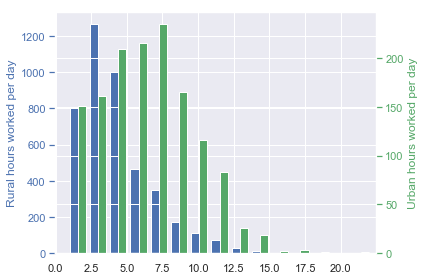

In [67]:
fig, ax1 = plt.subplots()
colors = ['b','g']
ax2 = ax1.twinx()
ax1.hist([ruralh, urbanh], bins=15, color=colors)
n, bins, patches = ax1.hist([ruralh,urbanh], bins=15)
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * 0.4
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Rural hours worked per day", color=colors[0])
ax2.set_ylabel("Urban hours worked per day", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
#plt.xlim(0,500000)
plt.tight_layout()
plt.show()

Majority of surveyed households work typically less than 7.5 hours per day, or less than 42 hours per week. As it was said before, overall in urban areas people work slightly more hours.

In [68]:
# by gender hours worked
menh = np.array(h_working_age.loc[h.sex==1, "h_worked_day"].dropna())
womenh = np.array(h_working_age.loc[h.sex==2, "h_worked_day"].dropna())

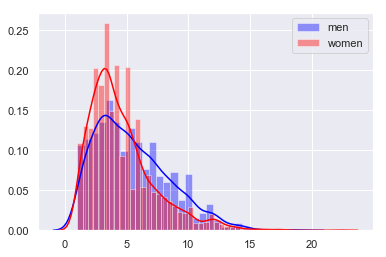

In [69]:
sns.distplot( menh , color="blue", label="men")
sns.distplot( womenh , color="red", label="women")

plt.legend()

Majority of people work in the range of 2.5-5 hours per day on average (for 7 working days). For those who work in this range there are slightly more women represented in this survey, whereas for higher values of hours worked there are slightly more men presented.

In [70]:
# hours worked by education
ed1 = np.array(h_working_age.loc[h.ed==1, "h_worked_day"].dropna())
ed2 = np.array(h_working_age.loc[h.ed==2, "h_worked_day"].dropna())
ed3 = np.array(h_working_age.loc[h.ed==3, "h_worked_day"].dropna())

C:\Users\adamw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


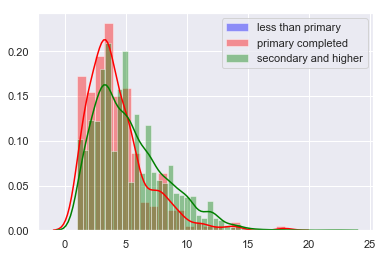

In [71]:
sns.distplot( ed1 , color="blue", label="less than primary")
sns.distplot( ed2 , color="red", label="primary completed")
sns.distplot( ed3 , color="green", label="secondary and higher")
plt.legend()

Hours worked per day by the level of education: majority of the heads of the households in the survey that completed primary or secondary and higher education work less than 5 hours per day.

With increase of hours worked we can also see prevailence of people with secondary and higher education, whereas for lower amount of hours worked there are more people with primary education represented.

# 3. Inequality across space

## 3.1. By Regions Inequality

In [72]:
by_region = All.groupby(by="region")[["all", "Total_total_income_dollars", "wealth_value"]].mean()

In [73]:
by_region

,all,Total_total_income_dollars,wealth_value
region,,,
Central,"2,610.60",926.88,"1,410.01"
Eastern,"2,396.60",430.68,"1,133.47"
Northern,"2,170.10",286.28,692.70
Western,"2,488.41",562.68,"1,224.76"


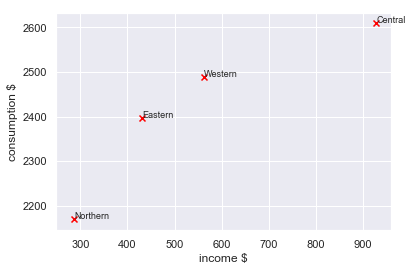

In [74]:
#plt.scatter(cons_by_region["Total_total_income"], cons_by_region["all"])

x_coords = by_region["Total_total_income_dollars"]
y_coords = by_region["all"]
types=['Central', 'Eastern', 'Northern', 'Western']
for i,type in enumerate(types):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.3, y+0.3, type, fontsize=9)
    plt.xlabel('income $')
    plt.ylabel('consumption $')
plt.show()

#plt.text(np.array(cons_by_region["Total_total_income"]), np.array(cons_by_region["all"]), types, fontsize=9)

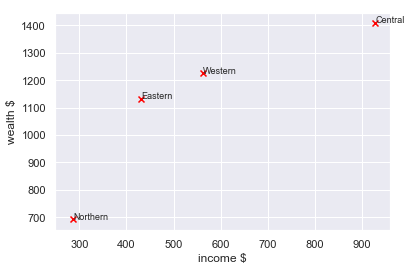

In [75]:
x_coords = by_region["Total_total_income_dollars"]
y_coords = by_region["wealth_value"]
types=['Central', 'Eastern', 'Northern', 'Western']
for i,type in enumerate(types):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.3, y+0.3, type, fontsize=9)
    plt.xlabel('income $')
    plt.ylabel('wealth $')
plt.show()

By income we can see clear segregation of the regions: the lowest values are related to Northern district, and the highest for he Central.

In [76]:
# labor supply
newid = []
for index, row in h_working_age.iterrows() :
    newid.append(int(row["HHID"].replace("H", '').replace("-", '')))
h_working_age["HHID"] = newid

In [77]:
All_s= pd.merge(All, h_working_age, on="HHID", how="outer")

In [78]:
All_s=All_s.loc[(All_s.Total_total_income_dollars.notnull())&(All_s.wealth_value.notnull())]

In [79]:
All_s_by_region = All_s.groupby(by="region")[["Total_total_income_dollars", "h_worked_day"]].mean()

In [80]:
All_s_by_region

,Total_total_income_dollars,h_worked_day
region,,
Central,760.40,4.97
Eastern,454.87,4.37
Northern,345.02,3.62
Western,563.15,4.92


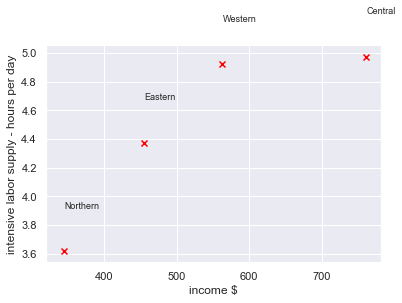

In [81]:
x_coords = All_s_by_region["Total_total_income_dollars"]
y_coords = All_s_by_region["h_worked_day"]
types=['Central', 'Eastern', 'Northern', 'Western']
for i,type in enumerate(types):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.3, y+0.3, type, fontsize=9)
    plt.xlabel('income $')
    plt.ylabel('intensive labor supply - hours per day')
plt.show()

Labor supply by regions follows the same pattern as income: the lowest values are related to Northern district, and the highest for he Central.